<a href="https://colab.research.google.com/github/Novadotgg/Quantactus-hiring/blob/main/Quantacus_Hiring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantactus Hiring challenge solution by Sayan Das, M.Tech 2nd year CSE, IIIT Tiruchirappalli**

**Importing all the necessary packages**

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

**Loading the given three datasets and observing the data**

In [46]:
email_df = pd.read_csv('email_table.csv')
opened_df = pd.read_csv('email_opened_table.csv')
clicked_df = pd.read_csv('link_clicked_table.csv')
print(email_df.head())
print(opened_df.head())
print(clicked_df.head())

   email_id   email_text email_version  hour    weekday user_country  \
0     85120  short_email  personalized     2     Sunday           US   
1    966622   long_email  personalized    12     Sunday           UK   
2    777221   long_email  personalized    11  Wednesday           US   
3    493711  short_email       generic     6     Monday           UK   
4    106887   long_email       generic    14     Monday           US   

   user_past_purchases  
0                    5  
1                    2  
2                    2  
3                    1  
4                    6  
   email_id
0    284534
1    609056
2    220820
3    905936
4    164034
   email_id
0    609056
1    870980
2    935124
3    158501
4    177561


Combining the datasets based on the clicked link of the mail and opening of the mails

In [47]:
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

# **What percentage of users opened the email and what percentage clicked on the link within the email?**

In [48]:
total_emails = len(email_df)
open_rate = email_df['opened'].mean() * 100
ctr = email_df['clicked'].mean() * 100
print(f"Percentage of users opened mail: {(open_rate)}")
print(f"Percentage of users clicked on the mail: {(ctr)}")

Percentage of users opened mail: 10.345
Percentage of users clicked on the mail: 2.119


Checking the correlation with eachother

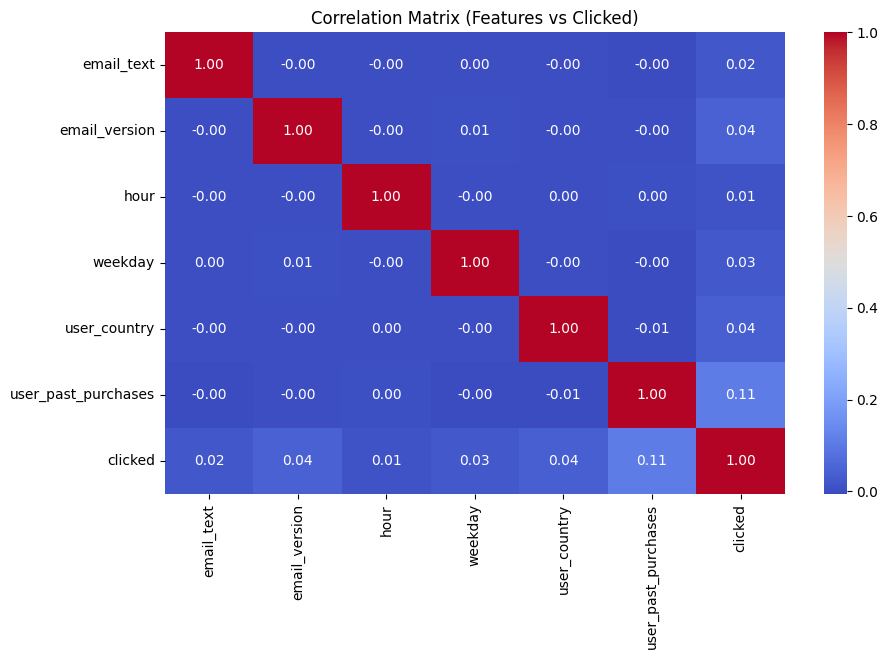

In [49]:
from sklearn.preprocessing import LabelEncoder
df_corr = email_df.copy()
df_corr['clicked'] = df_corr['email_id'].isin(clicked_df['email_id']).astype(int)
for col in ['email_text', 'email_version', 'weekday', 'user_country']:
    df_corr[col] = LabelEncoder().fit_transform(df_corr[col])
numeric_cols = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases', 'clicked']
corr_matrix = df_corr[numeric_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Features vs Clicked)')
plt.show()

Checking the correlation of the features with the target, i.e. clicked

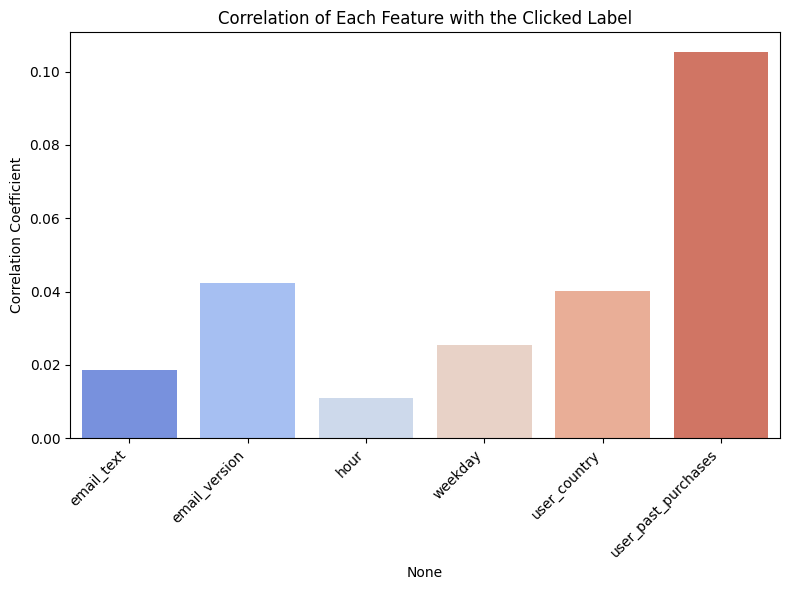

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df_corr = email_df.copy()
df_corr['clicked'] = df_corr['email_id'].isin(clicked_df['email_id']).astype(int)
for col in ['email_text', 'email_version', 'weekday', 'user_country']:
    df_corr[col] = LabelEncoder().fit_transform(df_corr[col])
numeric_cols = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases', 'clicked']

correlation = df_corr[numeric_cols].corr()['clicked'].drop('clicked')
plt.figure(figsize=(8, 6))
sns.barplot(x=correlation.index, y=correlation.values, palette='coolwarm')
plt.title('Correlation of Each Feature with the Clicked Label')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Preparing the data for classification<br>**

*   The training size consists of 80% of the data and testing for 20% data taken as default.<br>
*   The feature is_personalised is converted to either 0 or 1<br>

*   The feature is_long_text is converted to either 0 or 1








In [51]:
email_df['is_personalized'] = (email_df['email_version'] == 'personalized').astype(int)
email_df['is_long_text'] = (email_df['email_text'] == 'long_text').astype(int)
email_df['hour_bin'] = pd.cut(email_df['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
features = pd.get_dummies(email_df[['is_personalized', 'is_long_text',  'user_past_purchases', 'hour_bin', 'weekday', 'user_country']])
X = features
y = email_df['clicked']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **The VP of marketing thinks that it is stupid to send emails in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email?**

In [52]:
#using random forest ensemble model for classification
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
email_df['click_probability'] = model.predict_proba(X)[:, 1]
from sklearn.metrics import classification_report
acc=model.score(X_test,y_test)
print(f"Accuracy of the model: {acc*100}%")

Accuracy of the model: 97.72%


# **By how much do you think your model would improve click through rate (defined as # of users who click on the link/total users who receive the email). How would you test that?**

In [53]:
threshold = email_df['click_probability'].quantile(0.5)
top_users = email_df[email_df['click_probability'] > threshold]
potential_ctr = top_users['clicked'].mean() * 100
lift = (potential_ctr - ctr) / ctr * 100
print(f"\n. Model Performance Estimation:")
print(f"- Current CTR: {ctr:.2f}%")
print(f"- Expected CTR targeting top 50%: {potential_ctr:.2f}%")
print(f"- Potential Lift: {lift:.2f}%")


. Model Performance Estimation:
- Current CTR: 2.12%
- Expected CTR targeting top 50%: 3.94%
- Potential Lift: 85.79%


In the above section is an estimae of how much Click Through rate will improve if we only sent emails to users who are most likely to click, instead of sending randomly to everyone.<br>

```
email_df['click_probability']
```
contains the model's predicted probability (0-1) for each user to click
```
.quantile(0.5)
```
calculates the median probability (50th percentile), which gives a cutoff where 50% of users have higher probabilities



# **Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.**

Email content analysis

In [54]:
content_ctr = email_df.groupby(['email_text', 'email_version'])['clicked'].mean().unstack()
print("\n Email Content Performance:")
print(content_ctr)


 Email Content Performance:
email_version   generic  personalized
email_text                           
long_email     0.013711      0.023403
short_email    0.016578      0.031231


Time analysis

In [55]:
email_df['hour_bin'] = pd.cut(email_df['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
time_ctr = email_df.groupby(['weekday', 'hour_bin'])['clicked'].mean().unstack()
print("\n Time Performance:")
print(time_ctr)


 Time Performance:
hour_bin      Night   Morning  Afternoon   Evening
weekday                                           
Friday     0.010309  0.015485   0.016595  0.012346
Monday     0.020910  0.024876   0.021345  0.021472
Saturday   0.016445  0.017878   0.018970  0.025424
Sunday     0.014368  0.019799   0.012973  0.017094
Thursday   0.017882  0.028417   0.025828  0.016447
Tuesday    0.019314  0.028714   0.026523  0.008955
Wednesday  0.023219  0.032416   0.025348  0.011429


User country analysis

In [56]:
country_ctr = email_df.groupby('user_country')['clicked'].mean().sort_values(ascending=False)
print("\n Top Performing Countries:")
print(country_ctr.head())


 Top Performing Countries:
user_country
UK    0.024675
US    0.024360
ES    0.008327
FR    0.008004
Name: clicked, dtype: float64


purchase patterns

In [57]:
purchase_ctr = email_df.groupby('user_past_purchases')['clicked'].mean()
print("\n CTR by Past Purchases:")
print(purchase_ctr)


 CTR by Past Purchases:
user_past_purchases
0     0.000504
1     0.011199
2     0.015342
3     0.016560
4     0.021409
5     0.022230
6     0.032056
7     0.030739
8     0.039608
9     0.045510
10    0.046551
11    0.056021
12    0.065678
13    0.065744
14    0.091160
15    0.117021
16    0.117647
17    0.083333
18    0.028571
19    0.200000
20    0.000000
21    0.500000
22    1.000000
Name: clicked, dtype: float64


**Let's visualize the data**

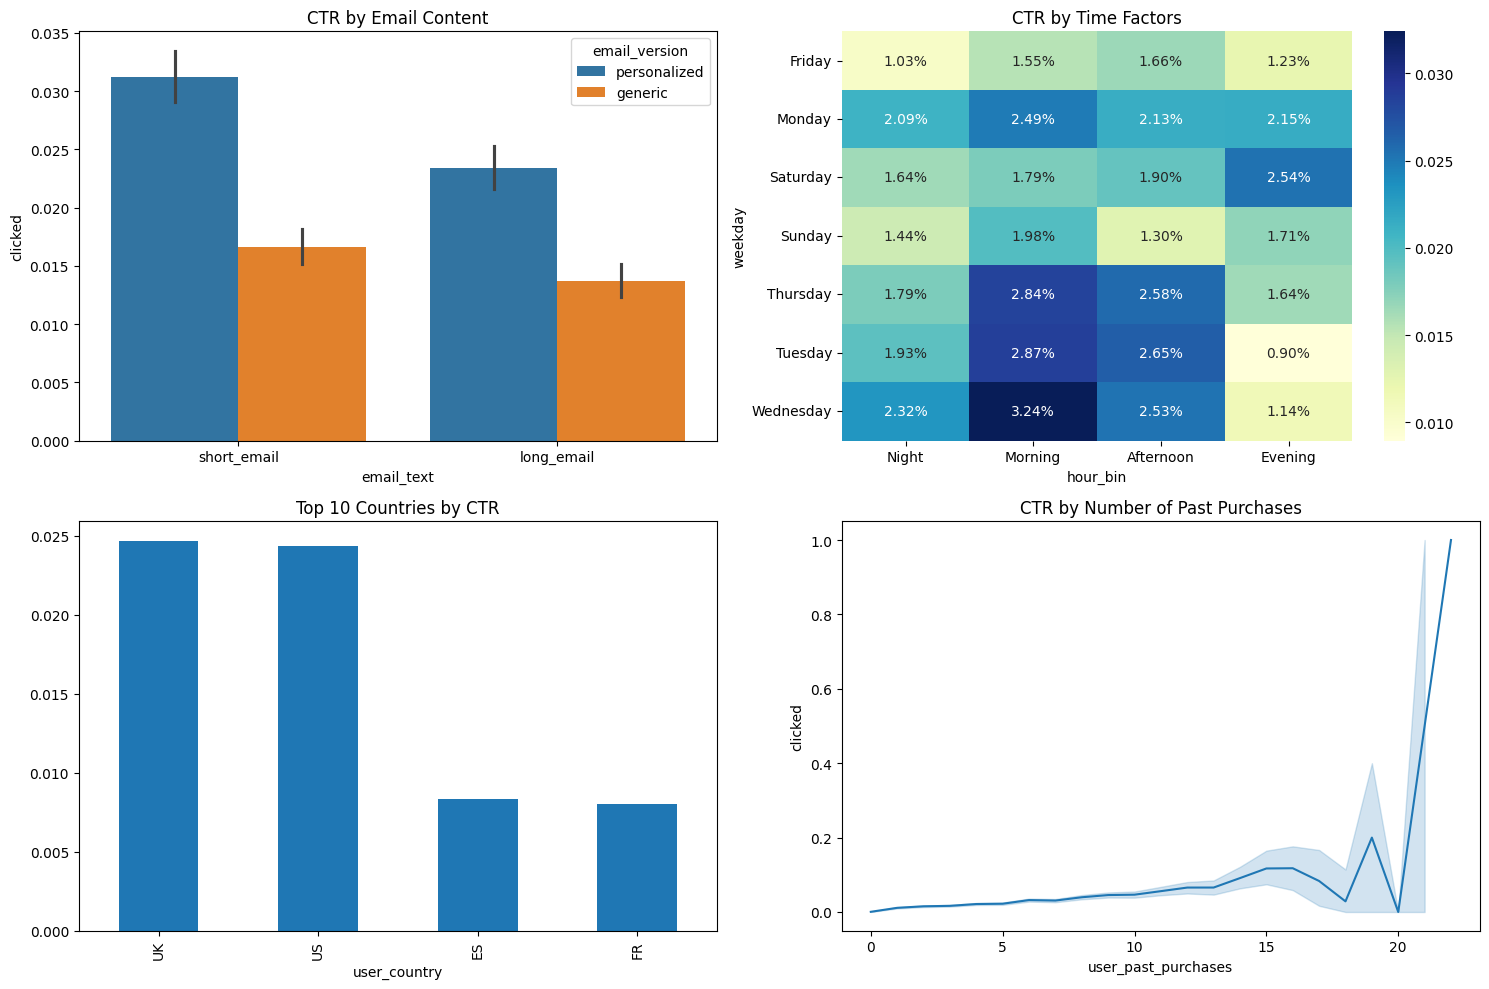

In [58]:
plt.figure(figsize=(15, 10))

# Plot 1: Email Content CTR
plt.subplot(2, 2, 1)
sns.barplot(x='email_text', y='clicked', hue='email_version', data=email_df)
plt.title('CTR by Email Content')

# Plot 2: Time Analysis
plt.subplot(2, 2, 2)
sns.heatmap(time_ctr, annot=True, fmt=".2%", cmap='YlGnBu')
plt.title('CTR by Time Factors')

# Plot 3: Country Performance
plt.subplot(2, 2, 3)
country_ctr.head(10).plot(kind='bar')
plt.title('Top 10 Countries by CTR')

# Plot 4: Past Purchases
plt.subplot(2, 2, 4)
sns.lineplot(x=email_df['user_past_purchases'], y=email_df['clicked'])
plt.title('CTR by Number of Past Purchases')

plt.tight_layout()
plt.show()

**According to the data observed:<br>**
* Short and personalized mails have good click through rate, so prioritizing
short and personal mails will be a better approach to increase click through rate.<br>
* Sending morning mails are better compared to evening
* Weekdays are good to send compared to weekends except saturday evening and avoid tuesday and wednesday evenings
* UK and US has higher click through rate
but France and spain underperforms so need to check why they are not clicking up the links
* Old purchases have good click through rate compared to new purchases
Building loyalty programs can help gain more click through rate.

**Key solutions and conclusion**

* Replace long mails with short mails.
* Schedule caampaigns to mostly Wednesday or Thursday mornings.
* Experiment and test with Saturday evening if the click through rate increases.
* Experiment with France and Spain what strategies might increase their click through rate
* Developing loyalty programms for the loyal purchasing customers to increase purchase frequency
* Check for the new users and segment the campaigns for old and new users.


